In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('Hotel Reservations.csv')
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [2]:
feature_name = 'avg_price_per_room'

# Calculate the IQR
Q1 = df[feature_name].quantile(0.25)
Q3 = df[feature_name].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold for outliers (e.g., 1.5 times the IQR)
outlier_threshold = 1.5

# Identify outliers based on the IQR
outliers = df[(df[feature_name] < Q1 - outlier_threshold * IQR) | (df[feature_name] > Q3 + outlier_threshold * IQR)]

# Print or visualize the outliers
#print("Outliers:")
#print(outliers)

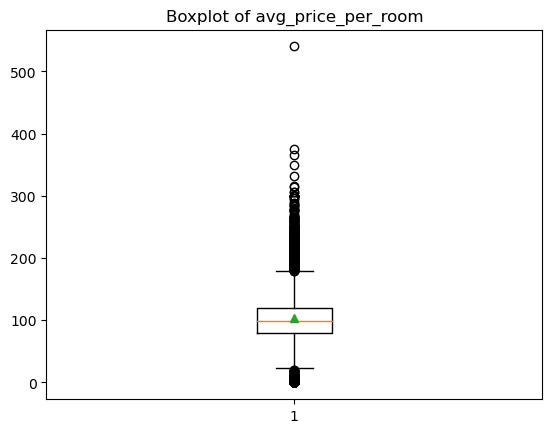

(34579, 19) 2


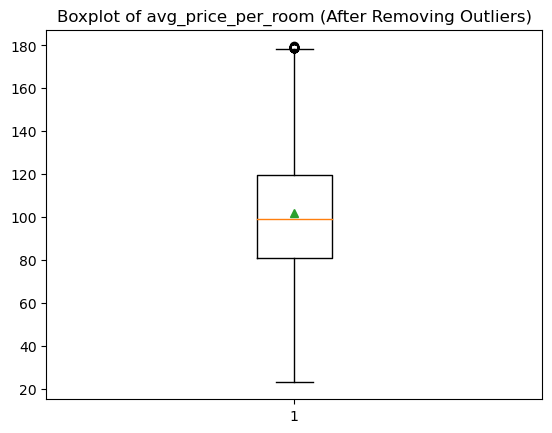

In [3]:
plt.boxplot(df.avg_price_per_room, showmeans=True)
plt.title('Boxplot of avg_price_per_room')
plt.show()
# removing the outliers
# Calculate IQR for the column
Q1 = df['avg_price_per_room'].quantile(0.25)
Q3 = df['avg_price_per_room'].quantile(0.75)
IQR = Q3 - Q1
# Identify and remove outliers
df = df[~((df['avg_price_per_room'] < (Q1 - 1.5 * IQR)) | (df['avg_price_per_room'] > (Q3 + 1.5 * IQR)))]
print(df.shape, "2") # (34579, 19)
plt.boxplot(df.avg_price_per_room, showmeans=True)
plt.title('Boxplot of avg_price_per_room (After Removing Outliers)')
plt.show()

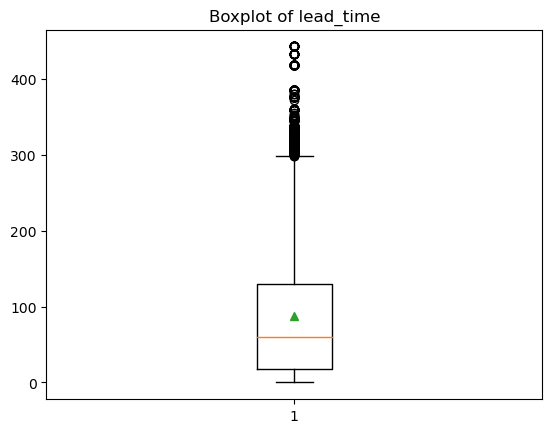

(33462, 19) 3


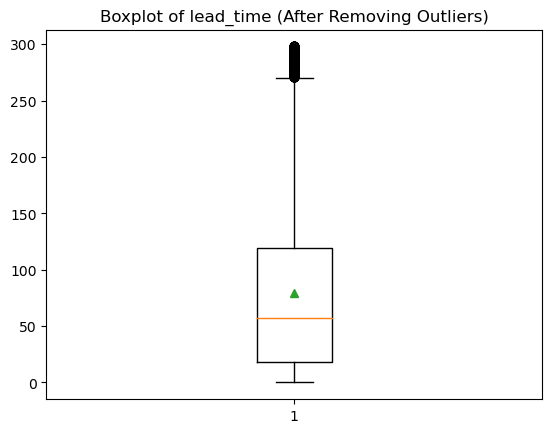

In [4]:
plt.boxplot(df.lead_time, showmeans=True)
plt.title('Boxplot of lead_time')
plt.show()
Q1 = df['lead_time'].quantile(0.25)
Q3 = df['lead_time'].quantile(0.75)
IQR = Q3 - Q1
# Identify and remove outliers
df = df[~((df['lead_time'] < (Q1 - 1.5 * IQR)) | (df['lead_time'] > (Q3 + 1.5 * IQR)))]
print(df.shape, "3") # (33462, 19)
plt.boxplot(df.lead_time, showmeans=True)
plt.title('Boxplot of lead_time (After Removing Outliers)')
plt.show()

In [5]:
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


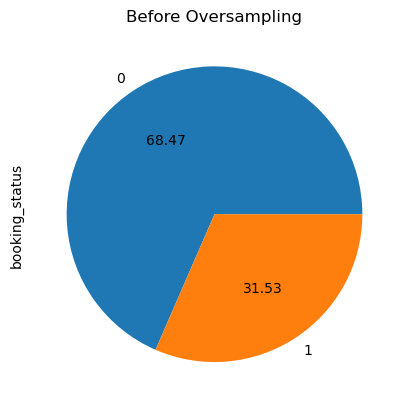

In [6]:
df['type_of_meal_plan'] = df['type_of_meal_plan'].replace({
    "Not Selected": 0,
    "Meal Plan 1": 1, 
    "Meal Plan 2": 2,
    "Meal Plan 3": 3,
    
})

df['room_type_reserved'] = df['room_type_reserved'].replace({
    "Room_Type 1": 1,
    "Room_Type 2": 2,
    "Room_Type 3": 3,
    "Room_Type 4": 4,
    "Room_Type 5": 5,
    "Room_Type 6": 6,
    "Room_Type 7": 7,
})

df['market_segment_type'] = df['market_segment_type'].replace({
    "Online": 1,
    "Offline": 2,
    "Corporate": 3,
    "Aviation": 4,
    "Complementary": 5,
    
})

df = df.drop('Booking_ID', axis=1)

df['booking_status'] = df['booking_status'].replace({
    "Canceled": 1,
    "Not_Canceled": 0,
})

X = df.drop('booking_status', axis=1).copy()
y = df['booking_status'].copy()

ax = y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Before Oversampling")

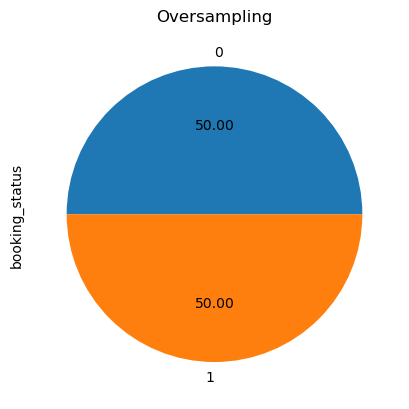

In [7]:
ros = SVMSMOTE(random_state=0)
X_res, y_res = ros.fit_resample(X, y)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Oversampling")

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

In [9]:
model_xgb = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=1000,
    early_stopping_rounds: 10,
    subsample=0.5,
    colsample_bytree=0.5,
    eval_metric='auc',
    verbosity=1
)

In [10]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [1, 0.1, 0.01]
    'reg_lambda': [1, 0.1, 0.01]
}

grid_search = GridSearchCV(estimator=xgb_classifier4, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

In [11]:
#model_xgb = xgb.XGBClassifier(**best_params)
model_xgb.fit(X_train, y_train)

# Predict on the training data
y_train_pred = model_xgb.predict(X_train)

# Predict on the test data using the final model
y_pred = model_xgb.predict(X_test)

In [12]:
# Evaluate the final model's performance using accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("==Training Data Metrics:==")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print("\n==Testing Data Metrics==")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1:.4f}")

==Training Data Metrics:==
Accuracy: 0.9380
Precision: 0.9382
Recall: 0.9379
F1 Score: 0.9380

==Testing Data Metrics==
Accuracy: 0.9006001091107474
Precision: 0.8972083964509846
Recall: 0.9048450458315146
F1 Score: 0.9010
